# 주제 : 추천 시스템 - 영화 데이터셋과 Rating Matrix를 활용하여 추천 모델 학습하기
----------
    
## 데이터 소개
    - 이번 주제는 MovieLens Dataset을 사용
    - 파일은 두 개 이며, 각각의 컬럼은 아래와 같d음
    
    1. ratings.dat
    user_id : 영화를 시청한 사용자 아이디
    movie_id : 영화의 아이디
    rating : 사용자가 영화를 평가한 점수
    time : 사용자가 영화를 시청한 시간
    
    2. movies.dat
    movie_id : 영화의 아이디
    title : 영화 제목
    genre : 영화 장르

    
- 데이터 출처: https://grouplens.org/datasets/movielens/


## 최종 목표
    - CF(Collaborative Filtering) 기반 추천 모델의 이해
    - Matrix Factorization 기반 추천 모델의 이해
    - KNN, SVD 알고리즘에 대한 이해
    - 훈련된 모델의 결과를 해석하는 방법 습득
    - 모델의 추천 결과를 평가하는 방법 습득
---

## Step 1. 데이터 전처리 과정

### 문제 1. 데이터 불러오기

In [ ]:
import pandas as pd

rating_url = 'https://raw.githubusercontent.com/yoonkt200/python-data-analysis/master/data/ml-1m/ratings.dat'
rating_df = pd.io.parsers.read_csv(rating_url, names=['user_id', 'movie_id', 'rating', 'time'], delimiter='::', engine ='python')
rating_df.head()

,user_id,movie_id,rating,time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [ ]:
movie_url = 'https://raw.githubusercontent.com/yoonkt200/python-data-analysis/master/data/ml-1m/movies.dat'
movie_df = pd.io.parsers.read_csv(movie_url, names=['movie_id', 'title', 'genre'], delimiter='::', engine ='python', encoding='ISO-8859-1')
movie_df.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


### 문제 2. EDA - 사용자 수와 영화의 수 탐색

In [ ]:
print(len(rating_df['user_id'].unique()))

6040


In [ ]:
print(len(rating_df['movie_id'].unique()))

3706


### 문제 3. EDA - 영화 평가 점수의 분포 탐색

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

<Axes: xlabel='rating', ylabel='Count'>

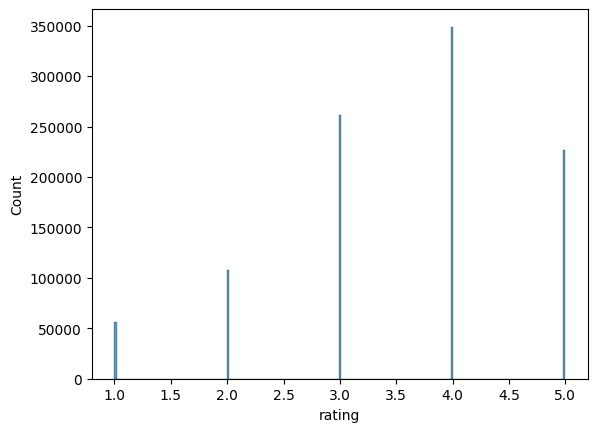

In [ ]:
sns.histplot(x=rating_df['rating'])

<Axes: >

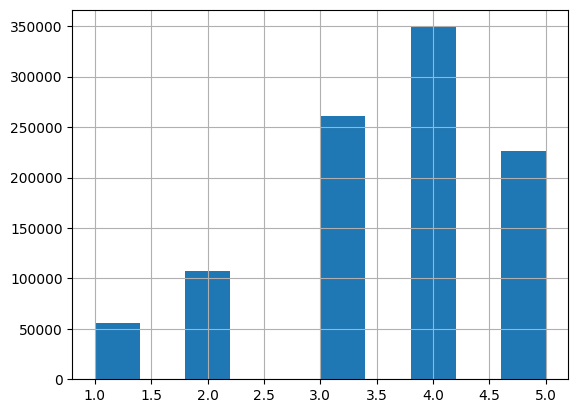

In [ ]:
rating_df['rating'].hist()

## Step 2. CF-based 모델링 (KNN)

### Rating Matrix와 Colaborative Filtering (CF)
----------

#### Rating Matrix

    1. User를 Row, Item을 Column으로 하며 Value를 Rating으로 하는 행렬
    2. Rating의 종류
      - Explicit Feedback : 영화 점수, 리뷰 점수, 좋아요 표시...
      - Implicit Feedback : 조회, 시청, 구매, 찜 표시...
    3. Rating Matrix를 추천 모델로 활용하는 방법
      - Colaborative Filtering (CF)
      - Matrix Factorization (MF)

-----

#### Colaborative Filtering (CF)

고객들의 선호도와 관심 표현을 바탕으로 선호도, 관심에서 비슷한 패턴을 가진 고객들을 식별해 내는 기법이다. 비슷한 취향을 가진 고객들에게 서로 아직 구매하지 않은 상품들은 교차 추천하거나 분류된 고객의 취향이나 생활 형태에 따라 관련 상품을 추천하는 형태의 서비스를 제공하기 위해 사용된다.
    
    1. User-based
    2. Item-based

-----

### 문제 4. 모델링 - Train/Test 데이터 분리

In [ ]:
# !pip install surprise --upgrade

In [ ]:
# !pip install numpy==1.26.4

In [ ]:
!python -c "import numpy as np; print(np.__version__)"

1.26.4


In [ ]:
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split

reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(rating_df[['user_id','movie_id','rating']],reader)
trainset, testset = train_test_split(data, test_size=0.2)

### 문제 5. 모델링 - KNN 모델 학습

-----

#### KNN (K-Nearest Neighbor) 알고리즘

![knn](http://i.imgur.com/gLBo1gX.png)

    [KNN의 대략적인 이해]
    1. 새로운(혹은 특정한) 데이터 포인트 X가 있을 때, X와 가장 유사한 k개를 이용하여 데이터 포인트 X의 위치를 찾는 알고리즘
    2. euclidean distance, cosine similarity 등을 기준으로 유사한 k개를 계산
    3. 분류(classification) 문제의 경우는 k개의 포인트에서 가장 많이 등장한 class로 할당
    4. 예측(regression) 문제의 경우는 k개 포인트의 평균 값, 혹은 가중치 값 등으로 X의 값을 예측

#### Surprise의 KNN

> A basic collaborative filtering algorithm. The prediction 𝑟̂ 𝑢𝑖 is set as

![suprise knn](https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/images/knn.png)

###### (https://surprise.readthedocs.io/en/stable/knn_inspired.html)
    
    [라이브러리의 대략적인 학습 과정]
    1. User-based CF
    2. 유저 A와 가장 영화를 유사하게 평가한 유저 k명을 선정
    3. k명의 유저가 영화 a를 평가한 점수를 활용하여 위의 식대로 점수를 계산함
    4. 이와 같은 방식으로 Rating Matrix를 완성
-----
    [Similarity]
    1. 가장 일반적인 Similarity 계산 방식은 cosine similarity
    2. 다른 방식은 euclidean distance, jaccard index, pearson correlation 등이 있음

![cosine](https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/images/cosine.png)
-----

In [ ]:
from surprise import KNNBasic

algo = KNNBasic(k=40, min=1, sim_option={'user_based':True, 'name':'cosine'})
algo.fit(trainset)
pred = algo.test(testset)

Computing the msd similarity matrix...
Done computing similarity matrix.


### 문제 6. 모델링 - RMSE 평가

In [ ]:
from surprise import accuracy

accuracy.rmse(pred)

RMSE: 0.8738


0.873785184834817

### 문제 7. 모델 평가 - 테스트 데이터셋에서 일부 결과 확인

In [ ]:
# test 함수의 결과를 활용하여 모델을 정성적으로 평가
predictions = algo.test(testset[:20])

for _, iid, r_ui, predicted_rating, _ in predictions:
  print("Item id", iid, "|", "real rating :", r_ui, "|", "predicted rating :", predicted_rating)

Item id 2160 | real rating : 4.0 | predicted rating : 4.1169318752115185
Item id 429 | real rating : 3.0 | predicted rating : 2.7033634600926812
Item id 527 | real rating : 5.0 | predicted rating : 4.899968802138784
Item id 2797 | real rating : 5.0 | predicted rating : 4.26750487335786
Item id 440 | real rating : 5.0 | predicted rating : 4.226059588726229
Item id 2542 | real rating : 4.0 | predicted rating : 4.325220302313804
Item id 3147 | real rating : 5.0 | predicted rating : 4.692047643293482
Item id 3168 | real rating : 4.0 | predicted rating : 3.8718619139718604
Item id 2721 | real rating : 5.0 | predicted rating : 3.874644018281554
Item id 367 | real rating : 2.0 | predicted rating : 2.7643015725896705
Item id 2478 | real rating : 3.0 | predicted rating : 3.1326318767178503
Item id 407 | real rating : 2.0 | predicted rating : 2.758656099842827
Item id 2193 | real rating : 4.0 | predicted rating : 4.077358351690272
Item id 508 | real rating : 3.0 | predicted rating : 4.0368571702

## Step 3. MF-based 모델링 (SVD)

### 문제 8. 모델링 - Train/Test 데이터 분리

In [ ]:
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(rating_df[['user_id','movie_id','rating']],reader)
trainset, testset = train_test_split(data, test_size=0.2)

### 문제 9. 모델링 - SVD 모델 학습

-----

#### Matrix Factorization의 개념

    [MF의 대략적인 이해]
    1. 원래의 행렬을 다른 2개 행렬로 분해하고, 이를 다시 원래 모양으로 만드는 과정을 Factorization 이라고 함.
    2. 그 과정에서 Latent Factor 라는 것을 활용하여, 행과 열의 성질을 만들어낼 수 있음.
    3. latent factor를 충분히 많이 만들게 되면, 유저와 아이템의 성질을 벡터로 표현 가능.
    4. 일반적으로 지도 학습을 통해 P와 Q를 찾게 되고, 이를 Model-based CF 라고 하기도 함.

#### Surprise의 SVD

> The famous SVD algorithm, as popularized by Simon Funk during the Netflix Prize. When baselines are not used, this is equivalent to Probabilistic Matrix Factorization
    
    [라이브러리의 대략적인 학습 과정]
    1. Model-based MF
    2. 이미 점수가 존재하는 r_ui를 기준으로 P, Q를 학습.
    3. 특정 epoch, 혹은 수렴 조건에 달할 때 까지 학습 (Gradient Descent)

-----

In [ ]:
from surprise import SVD

mf = SVD()
mf.fit(trainset)
pred = mf.test(testset)

### 문제 10. 모델링 - RMSE 평가

In [ ]:
accuracy.rmse(pred)

RMSE: 0.8755


0.8754535177012213

### 문제 11. 모델링 & 시각화 - RMSE를 개선하는 파라미터 튜닝 자동화

In [ ]:
import time

# 실험해볼 파라미터 리스트와 결과를 저장할 변수 정의
param_list = [10, 50, 100, 150, 200]
rmse_list_by_factors = []
ttime_list_by_factors = []

for n in param_list:
  train_start =time.time()
  mf = SVD(n_factors=n)
  mf.fit(trainset)
  train_end = time.time()
  print("training time of model: %.2f seconds" % (train_end - train_start))
  print("RMSE of test dataset in SVD model, n_factors=" + str(n))
  pred = mf.test(testset)
  rmse_result = accuracy.rmse(pred)
  rmse_list_by_factors.append(rmse_result)
  ttime_list_by_factors.append(train_end - train_start)
  print("------------------------------------")
print("searching n_factors is finish.")

training time of model: 8.16 seconds
RMSE of test dataset in SVD model, n_factors=10
RMSE: 0.8751
------------------------------------
training time of model: 12.03 seconds
RMSE of test dataset in SVD model, n_factors=50
RMSE: 0.8723
------------------------------------
training time of model: 16.05 seconds
RMSE of test dataset in SVD model, n_factors=100
RMSE: 0.8735
------------------------------------
training time of model: 21.90 seconds
RMSE of test dataset in SVD model, n_factors=150
RMSE: 0.8782
------------------------------------
training time of model: 24.60 seconds
RMSE of test dataset in SVD model, n_factors=200
RMSE: 0.8818
------------------------------------
searching n_factors is finish.


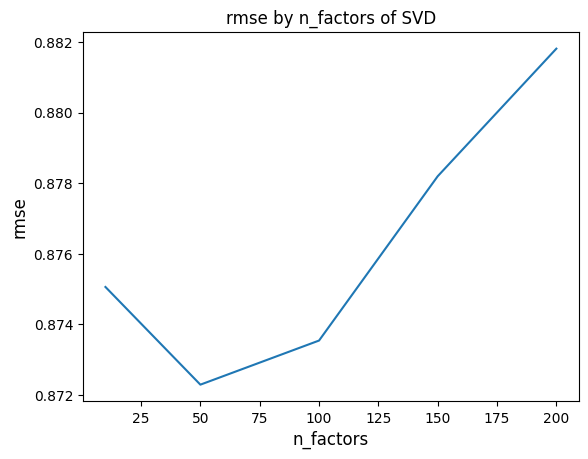

In [ ]:
plt.plot(param_list, rmse_list_by_factors)
plt.title('rmse by n_factors of SVD')
plt.ylabel('rmse', fontsize=12)
plt.xlabel('n_factors', fontsize=12)
plt.show()

### 문제 12. 모델 평가 - 최종 RMSE 평가

In [ ]:
mf = SVD(n_factors=50)
mf.fit(trainset)
pred = mf.test(testset)

accuracy.rmse(pred)

RMSE: 0.8723


0.8723375081565761

### 문제 13. 모델 평가 - 테스트 데이터셋에서 일부 결과 확인

In [ ]:
# test 함수의 결과를 활용하여 모델을 정성적으로 평가
pred = mf.test(testset[:20])

for _, iid, r_ui, predicted_rating, _ in pred:
    print("Item id", iid, "|", "real rating :", r_ui, "|", "predicted rating :", predicted_rating)

Item id 3844 | real rating : 4.0 | predicted rating : 3.4944514795224872
Item id 1206 | real rating : 4.0 | predicted rating : 4.364481257508628
Item id 3010 | real rating : 4.0 | predicted rating : 3.724544755408219
Item id 750 | real rating : 5.0 | predicted rating : 4.796787751618059
Item id 474 | real rating : 3.0 | predicted rating : 3.1767369187844103
Item id 1248 | real rating : 5.0 | predicted rating : 4.490308349851068
Item id 3508 | real rating : 4.0 | predicted rating : 4.2396066191437045
Item id 2112 | real rating : 4.0 | predicted rating : 3.4798936565674343
Item id 1233 | real rating : 3.0 | predicted rating : 4.425575541176126
Item id 333 | real rating : 4.0 | predicted rating : 3.5304883199913393
Item id 1197 | real rating : 4.0 | predicted rating : 3.9633622516969105
Item id 1367 | real rating : 3.0 | predicted rating : 2.296893829684168
Item id 2641 | real rating : 4.0 | predicted rating : 3.317584844811632
Item id 3261 | real rating : 3.0 | predicted rating : 3.49580

## Step 4. 추천 결과 평가

-----

#### CF, MF 기반 추천시스템의 가정(한계)

    [가정 : 사용자의 과거 Preference는 미래에서도 동일하다]
    1. Time Series로 추정된 선호도가 아닌, Estimate 되거나 Factorized 된 점수
    2. A시점에 평가한 선호도와, B시점에 평가한 선호도가 동일 선에서 학습됨
    3. Test 데이터에 대한 평가 역시, 시간이 고려되지 않은 "랜덤한 빈공간 찾기" 식으로 평가됨


### 문제 14. 추천 결과 평가 - 사용자별 전체 시청리스트 추출

In [ ]:
user_watch_dict_list = rating_df.groupby('user_id')[['user_id','movie_id']].apply(lambda x: list(x['movie_id'].to_list()))

In [ ]:
user_watch_dict_list

,0
user_id,
1,"[1193, 661, 914, 3408, 2355, 1197, 1287, 2804,..."
2,"[1357, 3068, 1537, 647, 2194, 648, 2268, 2628,..."
3,"[3421, 1641, 648, 1394, 3534, 104, 2735, 1210,..."
4,"[3468, 1210, 2951, 1214, 1036, 260, 2028, 480,..."
5,"[2987, 2333, 1175, 39, 288, 2337, 1535, 1392, ..."
...,...
6036,"[571, 574, 2053, 2054, 2058, 588, 589, 4, 3005..."
6037,"[589, 3006, 1407, 2064, 2065, 593, 3015, 903, ..."
6038,"[1419, 920, 3088, 232, 1136, 1148, 1183, 2146,..."


### 문제 15. 추천 결과 평가 - 특정 시간 기준 사용자별 Train/Test 시청리스트 추출
추천 결과 평가 - 특정 시간 기준 유저별 시청 목록 추출 (Train/Test과 동일 기준)

<Axes: >

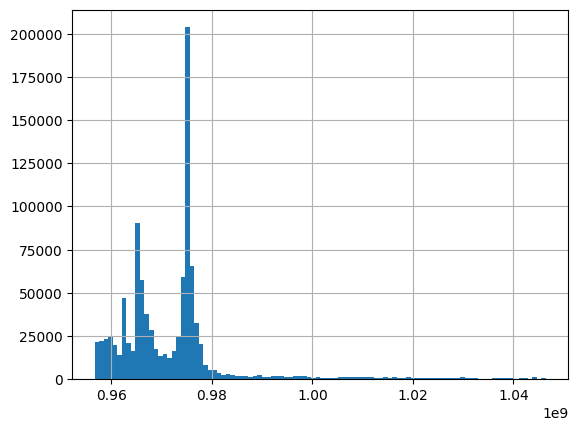

In [ ]:
# 시간별 시청 분포 탐색
rating_df['time'].hist(bins=100)

In [ ]:
# 8:2 로 분할할 수 있는 시간 지정
rating_df['time'].quantile(q=0.8, interpolation='nearest')

975768738

In [ ]:
train_df = rating_df[rating_df['time'] < 975768738][['user_id', 'movie_id', 'rating']]
test_df = rating_df[rating_df['time'] >= 975768738][['user_id', 'movie_id', 'rating']]

print(train_df.shape)
print(test_df.shape)

(800164, 3)
(200045, 3)


In [ ]:
print(len(train_df['movie_id'].unique()))
print(len(test_df['movie_id'].unique()))
print(len(rating_df['movie_id'].unique()))

3662
3511
3706


In [ ]:
print(len(train_df['user_id'].unique()))
print(len(test_df['user_id'].unique()))
print(len(rating_df['user_id'].unique()))

5400
1783
6040


In [ ]:
user_watch_dict_list_test = test_df.groupby('user_id')[['user_id', 'movie_id']].apply(lambda x: x['movie_id'].tolist())

In [ ]:
user_watch_dict_list_test

,0
user_id,
1,"[1193, 661, 914, 3408, 2355, 1197, 1287, 2804,..."
2,"[1357, 3068, 1537, 647, 2194, 648, 2268, 2628,..."
3,"[3421, 1641, 648, 1394, 3534, 104, 2735, 1210,..."
4,"[3468, 1210, 2951, 1214, 1036, 260, 2028, 480,..."
5,"[2987, 2333, 1175, 39, 288, 2337, 1535, 1392, ..."
...,...
6001,"[589, 1438, 965, 3481, 2875, 3147, 1552, 2917,..."
6002,"[3789, 3011, 1419, 3037, 902, 2098, 909, 3093,..."
6016,"[3795, 2062, 2065, 900, 3044, 1441, 914, 920, ..."


### 문제 16. 추천 결과 평가 - 모델 기반 사용자별 선호 시청리스트 추출

In [ ]:
data = Dataset.load_from_df(df=train_df, reader=reader)
train_data = data.build_full_trainset()
mf = SVD(n_factors=50)
mf.fit(train_data)

In [ ]:
# anti dataset 생성
test_data = train_data.build_anti_testset()

In [ ]:
pred = algo.test(testset[:20])

for uid, iid, _, predicted_rating, _ in pred:
    print("User id", uid, "|", "Item id", iid, "|", "predicted rating :", predicted_rating)

User id 3803 | Item id 3844 | predicted rating : 3.9359264318589373
User id 735 | Item id 1206 | predicted rating : 4.349670568420243
User id 1147 | Item id 3010 | predicted rating : 3.777058228552515
User id 5853 | Item id 750 | predicted rating : 4.807878468356689
User id 2537 | Item id 474 | predicted rating : 3.5845822894415393
User id 5636 | Item id 1248 | predicted rating : 4.501789097148109
User id 2271 | Item id 3508 | predicted rating : 4.24891867554855
User id 1243 | Item id 2112 | predicted rating : 3.736450949831972
User id 1278 | Item id 1233 | predicted rating : 4.462372342241954
User id 2907 | Item id 333 | predicted rating : 3.6048231842731417
User id 1748 | Item id 1197 | predicted rating : 4.074166450282246
User id 1050 | Item id 1367 | predicted rating : 2.9227716483617083
User id 4250 | Item id 2641 | predicted rating : 3.6373671462889448
User id 4169 | Item id 3261 | predicted rating : 3.5586622554025498
User id 2063 | Item id 2462 | predicted rating : 1.7271346916

In [ ]:
# 시청하지 않은 영화의 예상 점수
pred = mf.test(test_data)
estimated_unwatched_dict = {}

for uid, iid, _, predicted_rating, _ in pred:
  # 시청하지 않은 영화의 예상 점수 추출
  if uid in estimated_unwatched_dict:
    estimated_unwatched_dict[uid].append((iid, predicted_rating))
  else:
    estimated_unwatched_dict[uid] = [(iid, predicted_rating)]

### 문제 17. 추천 결과 평가 - 예상 선호 리스트와 실제 시청리스트로 MAP@K 계산

-----

    [Confusion Matrix와 Recall]
    1. 분류 문제에서 사용하는 대표적인 평가 기준
    2. 무언가의 실제 클래스(binary), 그리고 예상한 클래스(binary)를 비교하기 위한 매트릭스
    3. 이 중 Precision은 흔히 "정확도" 이라고 불리는 지표로, 맞다고 예측한 것 중에 실제로 맞는 것의 비율을 의미함.

-----

    [추천시스템과 Precision, Recall]
    1. 추천시스템에 이를 대입해보자
    2. 유저A가 실제로 시청한 영화들을 a, 모델이 유저 A가 볼 것이라고 예측한 영화들을 b라고 가정
    3. 이 때 모델이 10개의 영화를 예측 했다면 Top 10 Precision 계산할 수 있음.
    4. Recall 역시 마찬가지의 방법으로 구할 수 있음.
    5. Precision과 Recall에 대한 선택 기준은 상황마다 다르지만, 추천시스템에서 일반적으로 사용하는 지표는 "MAP"
    6. MAP(Mean Average Precision) : 추천시스템에서는 각 유저마다의 Precision을 계산한 뒤, 이것을 모든 추천 대상 유저로 확장하여 평균적인 지표를 계산한 것이라고 볼 수 있음.

In [ ]:
user_watch_dict_list_test = test_df.groupby('user_id')[['user_id','movie_id']].apply(lambda x: x['movie_id'].tolist())

In [ ]:
user_metric = []

# 유저별 k개의 선호 리스트 추출
k = 3

for user in estimated_unwatched_dict:
   # 선호 리스트 추출
   estimated_list = estimated_unwatched_dict[user].copy()
   estimated_list.sort(key=lambda tup: tup[1], reverse=True)
   try:
    top_k_prefer_list = [movie[0] for movie in estimated_list[:k]]
    actual_watch_list = user_watch_dict_list_test[int(user)]
    user_metric.append((user, top_k_prefer_list, actual_watch_list))
   except:
    print("list index out of range. exclude user" + str(user))

list index out of range. exclude user636
list index out of range. exclude user637
list index out of range. exclude user638
list index out of range. exclude user640
list index out of range. exclude user642
list index out of range. exclude user643
list index out of range. exclude user644
list index out of range. exclude user645
list index out of range. exclude user647
list index out of range. exclude user652
list index out of range. exclude user653
list index out of range. exclude user654
list index out of range. exclude user655
list index out of range. exclude user656
list index out of range. exclude user658
list index out of range. exclude user659
list index out of range. exclude user661
list index out of range. exclude user662
list index out of range. exclude user663
list index out of range. exclude user665
list index out of range. exclude user666
list index out of range. exclude user668
list index out of range. exclude user669
list index out of range. exclude user670
list index out o

In [ ]:
# 유저 한 명의 Precision 계산
predictive_values = user_metric[0][1]
actual_values = set(user_metric[0][2])
tp = [pv for pv in predictive_values if pv in actual_values]
len(tp) / len(predictive_values)

0.0

In [ ]:
# user metric를 인자로 받는 일반화된 Precision 계산 함수 정의
def get_map(user_list):
  precision_list = []
  for user in user_list:
    predictive_values = user[1]
    actual_values = set(user[2])
    tp = [pv for pv in predictive_values if pv in actual_values]
    precision = len(tp) / len(predictive_values)
    precision_list.append(precision)
  return sum(precision_list) / len(precision_list)

In [ ]:
get_map(user_metric)

0.15893846602508038

### 문제 18. 추천 결과 평가 & 시각화 - K 파라미터 별 추천 결과 시각화

In [ ]:
# user metric를 인자로 받는 일반화된 Precision 계산 함수 정의

def get_map_topk(k):
  user_metric = []
  for user in estimated_unwatched_dict:
    estimated_list = estimated_unwatched_dict[user].copy()
    estimated_list.sort(key=lambda tup: tup[1], reverse=True)
    try:
      top_k_prefer_list = [movie[0] for movie in estimated_list[:k]]
      actual_watch_list = user_watch_dict_list_test[user_watch_dict_list_test.index==user].values.tolist()[0]
      user_metric.append((user, top_k_prefer_list, actual_watch_list))
    except:
      pass

  precision_list = []
  for user in user_metric:
    predictive_values = user[1]
    actual_values = set(user[2])
    tp = [pv for pv in predictive_values if pv in actual_values]
    precision = len(tp) / len(predictive_values)
    precision_list.append(precision)
  return sum(precision_list) / len(precision_list)

In [ ]:
# 반복문, plot 함수를 활용하여 k 파라미터 튜닝 관찰 및 자동화
k_param_list = range(1,30)
map_list =[]

for k in k_param_list:
  map_list.append(get_map_topk(k))

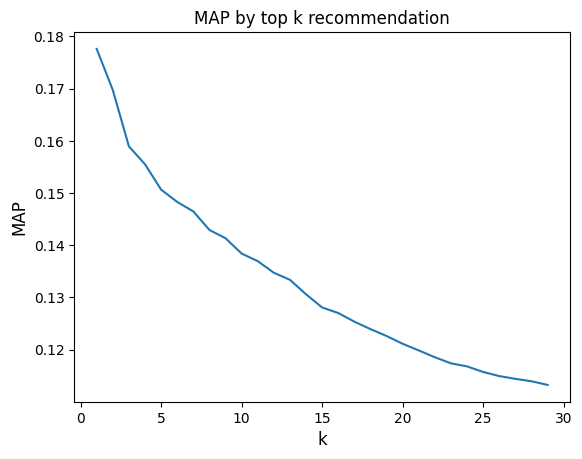

In [ ]:
plt.plot(k_param_list, map_list)
plt.title('MAP by top k recommendation')
plt.ylabel('MAP', fontsize=12)
plt.xlabel('k', fontsize=12)
plt.show()

# 결론

X축 (k): 사용자에게 추천하는 아이템 개수, 즉 Top-k에서의 k값 (1부터 30까지)

Y축 (MAP): 각 k에 대해 계산된 MAP 값

사용자별로 예측한 추천 결과의 정밀도를 평균한 값

## 특징
k가 작을수록 MAP이 높다

그래프가 왼쪽에서 가장 높은 값을 가지고 점차 감소한다.

적은 수의 추천 아이템(top-1, top-3 등)은 더 정확한 추천이 이루어진것을 의미한다

k가 증가할수록 MAP이 감소

추천 개수가 많아질수록 정확한 아이템을 포함할 확률은 올라가지만, precision은 떨어질 수 있다

즉, 정확한 추천을 더 많이 하기보다 희석되는 효과가 생긴것이다

## 인사이트:
상위 소수의 아이템 추천은 잘하지만, 추천 개수가 늘어날수록 불필요하거나 부정확한 아이템이 포함되는 경향이 있다

따라서 서비스 목적에 따라 top-3~5 정도가 적당할 수 있고, 너무 많은 추천은 precision을 떨어뜨릴 수 있다

## 결론:
추천 품질 측면에서 k가 작을 때 가장 효과적이다.

k 값이 클수록 정밀도(precision)가 낮아지는 구조이므로, 추천 개수는 사용자 니즈와 정확도 간의 균형을 고려해 정해야 할것이다.

